In [1]:
import os
import torch
import math
import json
import random
import shutil
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
from torchvision import datasets
from dataclasses import dataclass
from typing import List, Dict, Any
from torch.utils.data import DataLoader, random_split
from transformers import AutoImageProcessor, AutoModel, AutoConfig, get_cosine_schedule_with_warmup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/AIC Data/Project/Algae.v6i.coco.zip" -d "/content/drive/MyDrive/AIC Data/Project/dataset"

Archive:  /content/drive/MyDrive/AIC Data/Project/Algae.v6i.coco.zip
  inflating: /content/drive/MyDrive/AIC Data/Project/dataset/README.dataset.txt  
  inflating: /content/drive/MyDrive/AIC Data/Project/dataset/README.roboflow.txt  
   creating: /content/drive/MyDrive/AIC Data/Project/dataset/test/
  inflating: /content/drive/MyDrive/AIC Data/Project/dataset/test/_annotations.coco.json  
 extracting: /content/drive/MyDrive/AIC Data/Project/dataset/test/frame100_100966ms_jpg.rf.5752c3bb327cc5cbe5e87834d4bcc40f.jpg  
 extracting: /content/drive/MyDrive/AIC Data/Project/dataset/test/frame100_100966ms_jpg.rf.c8b42636bacc2bc33f230f92cffc7160.jpg  
 extracting: /content/drive/MyDrive/AIC Data/Project/dataset/test/frame102_102966ms_jpg.rf.071c51f5bebe0b885c2086e42edacb57.jpg  
 extracting: /content/drive/MyDrive/AIC Data/Project/dataset/test/frame102_102966ms_jpg.rf.c61ac488ccc86ccf77b047d3e5da53a5.jpg  
 extracting: /content/drive/MyDrive/AIC Data/Project/dataset/test/frame103_103966ms_jpg.

# Data Prep

In [ ]:
def coco_to_cropped_classification(
    coco_json_path,
    images_dir,
    output_dir,
    split="train"
):
    """
    Converts COCO annotations into a classification dataset consisting of
    cropped objects (one image per bounding box).
    """

    # Load COCO JSON
    with open(coco_json_path, 'r') as f:
        coco = json.load(f)

    # Category mapping
    categories = {cat["id"]: cat["name"] for cat in coco["categories"]}

    # Build image_id → file_name mapping
    id_to_filename = {img["id"]: img["file_name"] for img in coco["images"]}

    # Output root for this split
    split_root = os.path.join(output_dir, split)

    # Process each annotation (1 output per bbox)
    for ann in tqdm(coco["annotations"], desc=f"Processing {split} annotations"):

        image_id = ann["image_id"]
        category_id = ann["category_id"]
        bbox = ann["bbox"]  # COCO format: [x, y, width, height]

        class_name = categories[category_id]
        file_name = id_to_filename[image_id]
        image_path = os.path.join(images_dir, file_name)

        # Load image
        try:
            img = Image.open(image_path).convert("RGB")
        except:
            print("Failed to load:", image_path)
            continue

        x, y, w, h = bbox
        x2, y2 = x + w, y + h

        # Crop the bounding box
        crop = img.crop((x, y, x2, y2))

        # Create class folder
        class_folder = os.path.join(split_root, class_name)
        os.makedirs(class_folder, exist_ok=True)

        # Output filename (unique per annotation)
        ann_id = ann["id"]
        out_name = f"{os.path.splitext(file_name)[0]}_ann{ann_id}.jpg"
        out_path = os.path.join(class_folder, out_name)

        # Save crop
        crop.save(out_path)

In [ ]:
coco_root = "/content/drive/MyDrive/AIC Data/Project/dataset"
output_root = "/content/drive/MyDrive/AIC Data/Project/dataset_Cropped"

In [ ]:
ds = ["train", "valid", "test"]

for split in ds:
  coco_json = os.path.join(coco_root, split, "_annotations.coco.json")
  images_folder = os.path.join(coco_root, split)

  if os.path.exists(coco_json):
    coco_to_cropped_classification(
      coco_json_path=coco_json,
      images_dir=images_folder,
      output_dir=output_root,
      split=split
    )

Processing test annotations: 100%|██████████| 2134/2134 [01:57<00:00, 18.13it/s]


In [ ]:
train_dataset = datasets.ImageFolder(root=os.path.join(output_root, 'train'))
valid_dataset = datasets.ImageFolder(root=os.path.join(output_root, 'valid'))
test_dataset = datasets.ImageFolder(root=os.path.join(output_root, 'test'))

In [ ]:
num_train_classes = len(train_dataset.classes)
print("# of training classes:", num_train_classes)
num_valid_classes = len(valid_dataset.classes)
print("# of validation classes:", num_valid_classes)
num_test_classes = len(test_dataset.classes)
print("# of test classes:", num_test_classes)

# of training classes: 18
# of validation classes: 17
# of test classes: 17


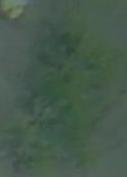

In [ ]:
Image.open(train_dataset.imgs[0][0])

# Training

In [3]:
class DinoV3Linear(nn.Module):
    def __init__(self, backbone: AutoModel, num_classes: int, freeze_backbone: bool = True):
        super().__init__()
        self.backbone = backbone
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False
            self.backbone.eval()

        hidden_size = getattr(backbone.config, "hidden_size", None)
        self.head = nn.Linear(hidden_size, num_classes)

    def forward(self, pixel_values):
        outputs = self.backbone(pixel_values=pixel_values)
        last_hidden = outputs.last_hidden_state
        cls = last_hidden[:, 0]
        logits = self.head(cls)
        return logits

In [ ]:
from huggingface_hub import login
login(new_session=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
MODEL_NAME = "facebook/dinov3-vitb16-pretrain-lvd1689m"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
backbone = AutoModel.from_pretrained(MODEL_NAME)
image_processor_config = json.loads(image_processor.to_json_string())
backbone_config = json.loads(AutoConfig.from_pretrained(MODEL_NAME).to_json_string())

In [ ]:
freeze_backbone = True
model = DinoV3Linear(backbone, num_train_classes, freeze_backbone=freeze_backbone).to(device)

In [ ]:
BATCH_SIZE = 1024
NUM_WORKERS = 8 # min(8, os.cpu_count() or 2)
EPOCHS = 15
LR = 5e-4
WEIGHT_DECAY = 1e-4
WARMUP_RATIO = 0.05
CHECKPOINT_DIR = "/content/drive/MyDrive/AIC Data/Project/weights"
EVAL_EVERY_STEPS = 13 # total samples / batch size

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

@dataclass
class Collator:
    processor: AutoImageProcessor

    def __call__(self, batch):
        # unpack (image, label) tuples
        images, labels = zip(*batch)

        rgb_images = [img.convert("RGB") if isinstance(img, Image.Image) else img for img in images]

        inputs = self.processor(images=rgb_images, return_tensors="pt")
        labels = torch.tensor(labels, dtype=torch.long)

        return {"pixel_values": inputs["pixel_values"], "labels": labels}

collate_fn = Collator(image_processor)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn,
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn,
)

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)
total_steps = EPOCHS * math.ceil(len(train_loader))
warmup_steps = int(WARMUP_RATIO * total_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
criterion = nn.CrossEntropyLoss()

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

/tmp/ipython-input-1575883391.py:52: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [ ]:
def evaluate() -> Dict[str, float]:
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for batch in valid_loader:
            pixel_values = batch["pixel_values"].to(device, non_blocking=True)
            labels = batch["labels"].to(device, non_blocking=True)
            logits = model(pixel_values)
            loss = criterion(logits, labels)
            loss_sum += loss.item() * labels.size(0)
            preds = logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return {
        "val_loss": loss_sum / max(total, 1),
        "val_acc": correct / max(total, 1),
    }

In [ ]:
best_acc = 0.0
global_step = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    model.backbone.eval()

    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for i, batch in enumerate(train_loader, start=1):
        pixel_values = batch["pixel_values"].to(device, non_blocking=True)
        labels = batch["labels"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(pixel_values)
        loss = criterion(logits, labels)

        preds = logits.argmax(dim=-1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item()
        global_step += 1

        if global_step % EVAL_EVERY_STEPS == 0:
            metrics = evaluate()
            train_loss_avg = running_loss / EVAL_EVERY_STEPS
            train_acc_avg = running_correct / running_total if running_total > 0 else 0.0

            print(
                f"[epoch {epoch} | step {global_step}] "
                f"train_loss={train_loss_avg:.4f} train_acc={train_acc_avg*100:.2f}% "
                f"val_loss={metrics['val_loss']:.4f} val_acc={metrics['val_acc']*100:.2f}%"
            )
            running_loss = 0.0
            running_correct = 0
            running_total = 0


            if metrics["val_acc"] > best_acc:
                best_acc = metrics["val_acc"]
                ckpt_path = os.path.join(CHECKPOINT_DIR, f"model_Cropped.pt")
                torch.save(
                    {
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "scheduler_state_dict": scheduler.state_dict(),
                        "config": {
                            "model_name": MODEL_NAME,
                            "classes": train_dataset.classes,
                            "backbone": backbone_config,
                            "image_processor": image_processor_config,
                            "freeze_backbone": freeze_backbone,
                        },
                        "step": global_step,
                        "epoch": epoch,
                    },
                    ckpt_path,
                )

    metrics = evaluate()
    print(
        f"END EPOCH {epoch}: val_loss={metrics['val_loss']:.4f} val_acc={metrics['val_acc']*100:.2f}% "
        f"(best_acc={best_acc*100:.2f}%)"
    )

The channel dimension is ambiguous. Got image shape torch.Size([3, 1, 1]). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


[epoch 1 | step 13] train_loss=1.7127 train_acc=49.32% val_loss=3.6862 val_acc=3.62%
END EPOCH 1: val_loss=3.7491 val_acc=4.17% (best_acc=3.62%)


The channel dimension is ambiguous. Got image shape torch.Size([3, 1, 1]). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


[epoch 2 | step 26] train_loss=1.2943 train_acc=56.84% val_loss=4.1162 val_acc=14.67%
END EPOCH 2: val_loss=4.1246 val_acc=16.06% (best_acc=14.67%)


The channel dimension is ambiguous. Got image shape torch.Size([3, 1, 1]). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


[epoch 3 | step 39] train_loss=0.9995 train_acc=69.83% val_loss=4.1466 val_acc=18.82%
END EPOCH 3: val_loss=4.1548 val_acc=18.97% (best_acc=18.82%)


The channel dimension is ambiguous. Got image shape torch.Size([3, 1, 1]). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


[epoch 4 | step 52] train_loss=0.8046 train_acc=73.16% val_loss=4.1466 val_acc=19.20%
END EPOCH 4: val_loss=4.1420 val_acc=19.37% (best_acc=19.20%)


The channel dimension is ambiguous. Got image shape torch.Size([3, 1, 1]). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


[epoch 5 | step 65] train_loss=0.6656 train_acc=74.92% val_loss=4.1306 val_acc=19.52%
END EPOCH 5: val_loss=4.1286 val_acc=19.72% (best_acc=19.52%)


The channel dimension is ambiguous. Got image shape torch.Size([3, 1, 1]). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


[epoch 6 | step 78] train_loss=0.5474 train_acc=76.29% val_loss=4.1395 val_acc=19.97%
END EPOCH 6: val_loss=4.1431 val_acc=20.05% (best_acc=19.97%)


The channel dimension is ambiguous. Got image shape torch.Size([3, 1, 1]). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


[epoch 7 | step 91] train_loss=0.4557 train_acc=77.61% val_loss=4.1529 val_acc=19.92%
END EPOCH 7: val_loss=4.1616 val_acc=19.97% (best_acc=19.97%)


The channel dimension is ambiguous. Got image shape torch.Size([3, 1, 1]). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


[epoch 8 | step 104] train_loss=0.3746 train_acc=78.63% val_loss=4.1951 val_acc=20.00%
END EPOCH 8: val_loss=4.2169 val_acc=20.30% (best_acc=20.00%)


The channel dimension is ambiguous. Got image shape torch.Size([3, 1, 1]). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


[epoch 9 | step 117] train_loss=0.3037 train_acc=78.81% val_loss=4.2265 val_acc=20.35%
END EPOCH 9: val_loss=4.2382 val_acc=20.43% (best_acc=20.35%)


The channel dimension is ambiguous. Got image shape torch.Size([3, 1, 1]). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


[epoch 10 | step 130] train_loss=0.2400 train_acc=79.44% val_loss=4.2404 val_acc=20.50%
END EPOCH 10: val_loss=4.2512 val_acc=20.53% (best_acc=20.50%)


The channel dimension is ambiguous. Got image shape torch.Size([3, 1, 1]). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


[epoch 11 | step 143] train_loss=0.1779 train_acc=79.59% val_loss=4.2509 val_acc=20.53%
END EPOCH 11: val_loss=4.2555 val_acc=20.48% (best_acc=20.53%)


The channel dimension is ambiguous. Got image shape torch.Size([3, 1, 1]). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


[epoch 12 | step 156] train_loss=0.1159 train_acc=80.18% val_loss=4.2595 val_acc=20.48%
END EPOCH 12: val_loss=4.2729 val_acc=20.50% (best_acc=20.53%)


The channel dimension is ambiguous. Got image shape torch.Size([3, 1, 1]). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


[epoch 13 | step 169] train_loss=0.0597 train_acc=78.12% val_loss=4.2734 val_acc=20.50%
[epoch 13 | step 182] train_loss=0.7591 train_acc=80.09% val_loss=4.2789 val_acc=20.48%
END EPOCH 13: val_loss=4.2789 val_acc=20.48% (best_acc=20.53%)


The channel dimension is ambiguous. Got image shape torch.Size([3, 1, 1]). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


[epoch 14 | step 195] train_loss=0.7484 train_acc=79.97% val_loss=4.2788 val_acc=20.40%
END EPOCH 14: val_loss=4.2789 val_acc=20.40% (best_acc=20.53%)


The channel dimension is ambiguous. Got image shape torch.Size([3, 1, 1]). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


[epoch 15 | step 208] train_loss=0.6862 train_acc=80.18% val_loss=4.2791 val_acc=20.43%
END EPOCH 15: val_loss=4.2791 val_acc=20.43% (best_acc=20.53%)


44 minutes on L4 GPU

# Example Predict

In [6]:
import transformers
import glob
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
train_images = glob.glob("/content/drive/MyDrive/AIC Data/Project/dataset_Cropped/train/*/*")
valid_images = glob.glob("/content/drive/MyDrive/AIC Data/Project/dataset_Cropped/valid/*/*")
test_images = glob.glob("/content/drive/MyDrive/AIC Data/Project/dataset_Cropped/test/*/*")

In [10]:
def get_image_label(image_dir):
  return image_dir.split('/')[-2]

get_image_label(train_images[0])

'P. Amplifolius'

In [9]:
ckpt_path = "/content/drive/MyDrive/AIC Data/Project/weights/model_Cropped_best.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load(ckpt_path, map_location=device)

ProcessorClass = getattr(transformers, ckpt["config"]["image_processor"]["image_processor_type"])
image_processor = ProcessorClass(**ckpt["config"]["image_processor"])
backbone = transformers.AutoModel.from_config(transformers.AutoConfig.for_model(**ckpt["config"]["backbone"]))
model = DinoV3Linear(
    backbone=backbone,
    num_classes=len(ckpt["config"]["classes"]),
    freeze_backbone=ckpt["config"].get("freeze_backbone", True),
).to(device)
classes = ckpt["config"]["classes"]

model.load_state_dict(ckpt["model_state_dict"])
model = model.eval()

In [11]:
def infer(images, device):
    with torch.no_grad():
        inputs = image_processor(images=images, return_tensors="pt").to(device)
        logits = model(inputs["pixel_values"])
        probs = torch.softmax(logits, dim=-1)
        pred = probs.argmax(dim=-1)
        outputs = []
        for i in range(len(images)):
            conf = probs[i, pred[i]]
            pred_label = classes[pred[i]]
            true_label = get_image_label(images[i])
            outputs.append((true_label, pred_label, float(conf)))
        return outputs

In [12]:
df = pd.DataFrame(columns=['Image', 'True Label', 'Predicted Label', 'Confidence'])

In [13]:
batch_size = 64
for i in range(0, len(test_images), batch_size):
    print(f'processing: {i+batch_size}/{len(test_images)}')
    image_paths = test_images[i:i+batch_size]
    inferences = infer(image_paths, device)
    result = [(img_path,) + inference for img_path, inference in zip(image_paths, inferences)]
    df = pd.concat([df, pd.DataFrame(result, columns=df.columns)], ignore_index=True)

processing: 64/2134


/tmp/ipython-input-2653497362.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(result, columns=df.columns)], ignore_index=True)


processing: 128/2134
processing: 192/2134
processing: 256/2134
processing: 320/2134
processing: 384/2134
processing: 448/2134
processing: 512/2134
processing: 576/2134
processing: 640/2134
processing: 704/2134
processing: 768/2134
processing: 832/2134
processing: 896/2134
processing: 960/2134
processing: 1024/2134
processing: 1088/2134
processing: 1152/2134
processing: 1216/2134
processing: 1280/2134
processing: 1344/2134
processing: 1408/2134
processing: 1472/2134
processing: 1536/2134
processing: 1600/2134
processing: 1664/2134
processing: 1728/2134
processing: 1792/2134
processing: 1856/2134
processing: 1920/2134
processing: 1984/2134
processing: 2048/2134
processing: 2112/2134
processing: 2176/2134


In [14]:
df.tail()

,Image,True Label,Predicted Label,Confidence
2129,/content/drive/MyDrive/AIC Data/Project/datase...,Snail,Clam Shell,0.428410
2130,/content/drive/MyDrive/AIC Data/Project/datase...,Snail,Clam Shell,0.641767
2131,/content/drive/MyDrive/AIC Data/Project/datase...,M. Tenellum,Algae,0.369838
2132,/content/drive/MyDrive/AIC Data/Project/datase...,M. Tenellum,Algae,0.304632
2133,/content/drive/MyDrive/AIC Data/Project/datase...,M. Tenellum,P. Amplifolius,0.276221


In [15]:
df['Confidence'].mean()

np.float64(0.6809937327108656)

In [22]:
df_metrics = pd.DataFrame(columns=['Class Name', 'Precision', 'Recall', 'F1 Score', 'TP', 'FP', 'FN', 'Support'])

for label in classes:
    tp = len(df[(df['True Label'] == label) & (df['Predicted Label'] == label)])
    fp = len(df[(df['True Label'] != label) & (df['Predicted Label'] == label)])
    fn = len(df[(df['True Label'] == label) & (df['Predicted Label'] != label)])
    support = tp + fn
    precision = (tp) / ((tp + fp) if (tp + fp) > 0 else 1)
    recall = tp / ((tp + fn) if (tp + fn) > 0 else 1)
    f1_score = 2 * (precision * recall) / ((precision + recall) if (precision + recall) > 0 else 1)
    df_metrics = pd.concat([df_metrics, pd.DataFrame([(label, round(precision, 3), round(recall, 3), round(f1_score, 3), tp, fp, fn, support)], columns=df_metrics.columns)], ignore_index=True)

/tmp/ipython-input-3551760248.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([(label, round(precision, 3), round(recall, 3), round(f1_score, 3), tp, fp, fn, support)], columns=df_metrics.columns)], ignore_index=True)


In [23]:
# get macro average and micro average from df_metrics
macro_precision = df_metrics['Precision'].mean()
macro_recall = df_metrics['Recall'].mean()
macro_f1_score = df_metrics['F1 Score'].mean()
micro_precision = sum(df_metrics['TP']) / (sum(df_metrics['TP']) + sum(df_metrics['FP']))
micro_recall = sum(df_metrics['TP']) / (sum(df_metrics['TP']) + sum(df_metrics['FN']))
micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)
total_tp = df_metrics['TP'].sum()
total_fp = df_metrics['FP'].sum()
total_fn = df_metrics['FN'].sum()
total_support = df_metrics['Support'].sum()
df_metrics = pd.concat([df_metrics, pd.DataFrame([('Micro Average',
                                                   round(micro_precision, 3),
                                                   round(micro_recall, 3),
                                                   round(micro_f1_score, 3),
                                                   '-', '-', '-', '-')], columns=df_metrics.columns)], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame([('Macro Average',
                                                   round(macro_precision, 3),
                                                   round(macro_recall, 3),
                                                   round(macro_f1_score, 3),
                                                   '-', '-', '-', '-')], columns=df_metrics.columns)], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame([('Total', '-', '-', '-',
                                                   total_tp,
                                                   total_fp,
                                                   total_fn,
                                                   total_support)], columns=df_metrics.columns)], ignore_index=True)

In [24]:
df_metrics

,Class Name,Precision,Recall,F1 Score,TP,FP,FN,Support
0,Algae,0.756,0.855,0.803,124,40,21,145
1,Clam Shell,0.927,0.947,0.937,89,7,5,94
2,Elodea Canadensis,0.333,0.05,0.087,1,2,19,20
3,Eriocaulon Septangulare,0.928,0.925,0.926,270,21,22,292
4,I. Lacustris,0.0,0.0,0.0,0,0,0,0
5,Leaves,0.933,0.341,0.5,14,1,27,41
6,M. Spicatum,0.0,0.0,0.0,0,0,22,22
7,M. Tenellum,0.0,0.0,0.0,0,0,3,3
8,Najas,0.0,0.0,0.0,0,0,18,18
9,P. Amplifolius,0.831,0.98,0.899,1041,212,21,1062


Predicted: P. Amplifolius, Conf: 0.8819584846496582


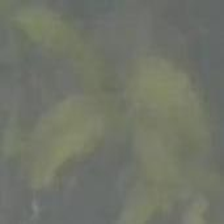

In [ ]:
image_path = np.random.choice(train_images)
image = Image.open(image_path)
pred, conf = infer(image, device)
print(f"Predicted: {pred}, Conf: {conf}")
display(image.resize((224, 224)))

In [ ]:
plt.figure(figsize = (20,20))
for i, idx in enumerate(np.random.choice(len(train_images), size=30, replace=False)):
    image = Image.open(train_images[idx])
    label = os.path.basename(os.path.dirname(train_images[idx]))
    pred, conf = infer(train_images, device)

    plt.subplot(5, 6, i+1)
    plt.imshow(train_images.resize((224, 224)))
    plt.title(f"Gth: {label}\nPred: {pred}\nConf: {conf}", fontdict = {'fontsize' : 8})
    plt.axis("off")

The channel dimension is ambiguous. Got image shape torch.Size([3, 1, 1]). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.
